# Report HW2

## Submitted by:
- **Adir Hilvert**
- **Tal Mirovsky**

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.display import Markdown as md
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from plotnine import * 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

%matplotlib inline
# We selected seed value of 42 as often use in Machine learning analysis
SEED = 42 

In [5]:
# Reading from Excel files into dataframes

df_cities = pd.read_excel('cities.xlsx')
df_crimes = pd.read_excel('crimes.xlsx')
df_mapping_city_type = pd.read_excel('mapping.xlsx','צורת יישוב')
df_mapping_counsils= pd.read_excel('mapping.xlsx', sheet_name=2, header = 11) # For mapping the counsils' city symbols

In [10]:
# Font styling for diagrams titles
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

# Tasks 1 +2:

### **A. Pre-processing**
----------------------------------------
We will perform Data cleaning, noise reduction and imputations as described below:

1. **Imputation: assigning 0 to all the crime amounts which are now assigned with "-"**
    - Assumption: (-) indicates 0 crimes in the Excel file<br>
    - Remark1: (-) were also removed from column "תאור קבוצה סטטיסטית" <br>


2. **Removing rows with total values in the crimes dataset (the total values in the Excel are incorrect).**
3. **Removing rows with undefined crime categories (after checking that their amount is insignificant):**
    - (תאור קבוצה סטטיסטית = "-") .
    - "סעיפי הגדרה". 
    - "לא ידוע".


4. **Calculated city ("יישוב מחושב") = "אחר"**<br>
Since "other" cities don't have demogrphic features and are all grouped into one single group, their crime data is not
helpful for us.
<br>
5. **Cities with city symbol  = -2 (Regional Councils):**<br>
  We noticed that multiple cities ("מועצות אזוריות") are included under this symbol value (-2), they are reigional councils. As the crime amount in them is substential (>8% out of the total), we will keep them but assign the city symbol defined in the mapping file. we noticed that one council "מועצה אזורית עמק לוד" exist in the mapping under a different name ('שדות דן) so we assigned this symbol (40) manually. 


6. **Removing unnecessary columns 'שנת הודעה','Total' from the crimes dataset.**


7. **Imputation:  assigning -1 to all null values of natural zones ('אזור טבעי') in cities dataframe.**

<font size="2">*General Remark - we chose a threshold of 1% (0.01) for the amount of data which could be removed by each cleaning action,
if the suspicous data is more than 1% of the total data, we consider this data as significant and chose not to ignore and keep it*</font>

In [6]:
# Original data:
print('Initial # of rows in crimes excel = ',df_crimes.shape[0])

                                             
# Step 1:
df_crimes = df_crimes.loc[(df_crimes['יישוב מחושב'] != 'Total') & (df_crimes['תאור קבוצה סטטיסטית'] != 'Total')]
print('\nStep 1:\n- After removing rows with totals: ',df_crimes.shape[0])

# Step 2:
print('\nStep 2:\n- Amount of values with (-) replaced with 0 = ',df_crimes.isin(['-']).sum().sum())

df_crimes.replace(to_replace ="-",
                  value =0,inplace = True)

# Step 3:
crimes_total_amount = df_crimes[[2014,2015,2016,2017,2018,2019]].sum().sum()
categorized_0 = df_crimes.loc[(df_crimes['תאור קבוצה סטטיסטית'] == 0),[2014,2015,2016,2017,2018,2019]].sum().sum()
categorized_definition = df_crimes.loc[(df_crimes['תאור קבוצה סטטיסטית'] == 'סעיפי הגדרה'),[2014,2015,2016,2017,2018,2019]].sum().sum()
categorized_unknown = df_crimes.loc[(df_crimes['תאור קבוצה סטטיסטית'] == 'לא ידוע'),[2014,2015,2016,2017,2018,2019]].sum().sum()
regional_counsils = df_crimes.loc[(df_crimes['סמל יישוב'] == -2),[2014,2015,2016,2017,2018,2019]].sum().sum()

print('\nStep 3:\n- Total Amount of crimes = ',crimes_total_amount)
print('\n- Amount of crimes with undefined category = ',categorized_0)
print('- % of crimes of "-" or "0" category out of all crimes =  ',round(categorized_0/crimes_total_amount,5),
      '==> insignificant\n')

print('\n- Amount of crimes with category = "definition"',categorized_definition)
print('- % of crimes of "סעיפי הגדרה" category out of all crimes =  ',round(categorized_definition/crimes_total_amount,5),
      '==> insignificant\n')

print('\n- Amount of crimes with unknown category = ',categorized_unknown)
print('- % of crimes of "לא ידוע" category out of all crimes ~  ',round(categorized_unknown/crimes_total_amount,5),
      '==> insignificant\n')

df_crimes = df_crimes.loc[df_crimes['תאור קבוצה סטטיסטית'] != 0]
print('- # rows after removing rows with empty crime catergory "0"  לאחר הסרת אפס כקטגוריה " ',df_crimes.shape[0])
df_crimes = df_crimes.loc[df_crimes['תאור קבוצה סטטיסטית'] != 'סעיפי הגדרה']
print('- # rows after removing rows with crime category "definition" =  לאחר הסרת קטגוריה "סעיפי הגדרה"  ',df_crimes.shape[0])
df_crimes = df_crimes.loc[df_crimes['תאור קבוצה סטטיסטית'] != 'לא ידוע']
print('- # rows after removing rows with crime category "Unknown" = לאחר קטגוריה הסרת "לא ידוע" ',df_crimes.shape[0])

# Step 4
df_crimes = df_crimes[df_crimes['יישוב מחושב']!= 'אחר']

# Step 5
print('\nStep 5:\n- Amount of crimes in rigional counsils = ',regional_counsils)
print('- % of crimes in councils out of all crimes =  ',round(regional_counsils/crimes_total_amount,5),
      '==> significant! not to be removed\n')
#mapping city symbols of council to the values in the mapping files
counsils = []
cities_of_crime_symb = list(map(int,df_crimes['סמל יישוב'].unique()))

for ind_crime, row_crime in df_crimes[df_crimes['סמל יישוב'] == -2].iterrows():
    if row_crime['יישוב מחושב'] == 'מועצה אזורית עמק לוד':
        df_crimes.at[ind_crime,'סמל יישוב'] = 40
        counsils.append(40)
    for ind_city, row_city in df_mapping_counsils.iterrows():
        if row_crime['יישוב מחושב'].find(row_city['המועצה האזורית']) != -1:
             df_crimes.at[ind_crime,'סמל יישוב'] = row_city['הסמל']
             counsils.append(row_city['הסמל'])
            
# assigning minus (-) sign to values symbols of cities in order to avoid duplicates with councils with same symbols
for row_ind,row in df_crimes[df_crimes['יישוב מחושב'].str.find('מועצה') != -1].iterrows():
        df_crimes.at[row_ind,'סמל יישוב'] = df_crimes.at[row_ind,'סמל יישוב']*-1

print("Number of councils which were assigned with symbol from mapping = ",len(set(counsils)))
# Step 6

df_crimes.drop(['שנת הודעה','Total'],
  axis='columns', inplace=True)

# Step 7
df_cities['אזור טבעי'] = df_cities['אזור טבעי'].fillna(-1)

Initial # of rows in crimes excel =  3683

Step 1:
- After removing rows with totals:  3426

Step 2:
- Amount of values with (-) replaced with 0 =  4409

Step 3:
- Total Amount of crimes =  2362199

- Amount of crimes with undefined category =  1991
- % of crimes of "-" or "0" category out of all crimes =   0.00084 ==> insignificant


- Amount of crimes with category = "definition" 2446
- % of crimes of "סעיפי הגדרה" category out of all crimes =   0.00104 ==> insignificant


- Amount of crimes with unknown category =  8
- % of crimes of "לא ידוע" category out of all crimes ~   0.0 ==> insignificant

- # rows after removing rows with empty crime catergory "0"  לאחר הסרת אפס כקטגוריה "  3227
- # rows after removing rows with crime category "definition" =  לאחר הסרת קטגוריה "סעיפי הגדרה"   3040
- # rows after removing rows with crime category "Unknown" = לאחר קטגוריה הסרת "לא ידוע"  3033

Step 5:
- Amount of crimes in rigional counsils =  195171
- % of crimes in councils out of all crimes

**Rearranging and grouping/aggregating demogrphic data of cities of regional councils (יישובים השייכים למועצות מקומיות)**<br>
We will consider each council as a single unit, demographic data will be extracted from all the cities of each council from the Cities excel,<br>
aggregated into values that represent the whole council

In [7]:
filt_muni = (df_cities['מעמד מונציפאלי'].isin(set(counsils)) & df_cities['מעמד מונציפאלי'].notnull()) 
filt_cities = (df_cities['סמל יישוב'].isin(cities_of_crime_symb))

#  freq_district/freq_subdistrict ('מחוז','נפה') -Imputation 
# we will calculate the frequent value for each in each council and assign it as the entire council value.

freq_district = df_cities[(filt_muni)].groupby(['מעמד מונציפאלי'])['מחוז'].agg(lambda x:x.value_counts().index[0])
freq_district = list(freq_district)

freq_subdistrict = df_cities[(filt_muni)].groupby(['מעמד מונציפאלי'])['נפה'].agg(lambda x:x.value_counts().index[0])
freq_subdistrict = list(freq_subdistrict)


# Natural_zone - Imputation 
# Natural zones of some rows is null we will assign -1 to them to denote "other"
natural_zone = df_cities[(filt_muni)].groupby(['מעמד מונציפאלי'])['אזור טבעי'].agg(lambda x:x.value_counts().index[0])
natural_zone = list(map(int,natural_zone))

# Metropoline_Association 
# From the 1202 cities in crimes file which belong to councils, 762 (63%) of the values of 'שיוך מוטרופוליני' are nulls.
# From the 201 cities which don't belong to councils, 112 (50%) of the values of 'שיוך מוטרופוליני' are nulls.
# Therefore, we choose to remove this column from our dataset

df_cities.drop(['שיוך מטרופוליני'], axis = 1,inplace=True)

# Religion - Imputation 
# 965/1202 (80%) (councils cities) and 135/224 (60%) in non councils cities have value of 1 (jewish cities), 
# therefore we choose to assign 1 to all the null values.
# In each council, We assign the most common religion of its cities

df_cities['דת יישוב'].fillna(1,inplace = True)
religion = df_cities[(filt_muni)].groupby(['מעמד מונציפאלי'])['דת יישוב'].agg(lambda x:x.value_counts().index[0])
religion = list(map(int,religion))

# Population2018 - Imputation
# We choose to replace the null values in each of the citis in councils with the population mean value in that council.
# First, we calculate the mean value of the population in each council (nulls aren't included), next we update each
# city (which belong to a council) with null values - to the mean value of that council. Finally, after all cities in each
# council have a population value, we sum all values and keep it in the council dataframe in column 'סך הכל אוכלוסייה 2018'

pop2018 = df_cities[(filt_muni)].groupby(['מעמד מונציפאלי'])['סך הכל אוכלוסייה 2018'].mean()
pop2018 = list(map(int,pop2018))

# Jews/Arabs - Imputation
# For null values we will update according to the following rule, if city religion  = 1 (jewish), 
# jewish population = city population,Arab and other  = 0.
# If religion  = 2 (not jewish) Arab population = city population, jewish and other  = 0
# After all nulls were updated, we sum all the values of each city in council and the sum is the value of that council.
# We decide to drop the column 'מזה יהודים' since it is very similar to 'יהודים ואחרים' and we dont se a point to keep both

for ind_council, row_council in df_cities[((filt_muni) | (filt_cities)) & (df_cities['יהודים ואחרים'].isnull() | df_cities['ערבים'].isnull())].iterrows():
    if df_cities.at[ind_council,'דת יישוב'] == 1:        
        df_cities.at[ind_council,'יהודים ואחרים'] = df_cities.at[ind_council,'סך הכל אוכלוסייה 2018']
        df_cities.at[ind_council,'ערבים'] = 0
    elif df_cities.at[ind_council,'דת יישוב'] == 2:
        df_cities.at[ind_council,'ערבים'] = df_cities.at[ind_council,'סך הכל אוכלוסייה 2018']
        df_cities.at[ind_council,'יהודים ואחרים'] = 0
    else: 
        df_cities.at[ind_council,'ערבים'] = df_cities.at[ind_council,'סך הכל אוכלוסייה 2018']/2
        df_cities.at[ind_council,'יהודים ואחרים'] = df_cities.at[ind_council,'סך הכל אוכלוסייה 2018']/2
        
jews_pop = df_cities[(filt_muni)].groupby(['מעמד מונציפאלי'])['יהודים ואחרים'].sum()
jews_pop = list(map(int,jews_pop))

arab_pop = df_cities[(filt_muni)].groupby(['מעמד מונציפאלי'])['ערבים'].sum()
arab_pop = list(map(int,arab_pop))

df_cities.drop(['מזה: יהודים'], axis = 1,inplace=True)

# City_type ('צורת יישוב שוטפת') - Imputation
# We will calculate the frequent value in each council and assign it as the entire council value.

city_type = df_cities[(filt_muni)].groupby(['מעמד מונציפאלי'])['צורת יישוב שוטפת'].agg(lambda x:x.value_counts().index[0])
city_type = list(map(int,city_type))

# we decide the following columns as we don't believe they will not be useful for the analysis.

# transcription ('תעתיק')
# Foundation year - ('שנת ייסוד')
# Organizational_association ('השתייכות ארגונית') -
# Coordinates ('קואורדינטות')
# Height ('גובה')
# Planning_commity ('ועדת תכנון')
# Year('שנה')
# English_name ('שם יישוב באנגלית')


df_cities.drop(['תעתיק'], axis = 1,inplace=True)
df_cities.drop(['שנת ייסוד'], axis = 1,inplace=True)
df_cities.drop(['השתייכות ארגונית'], axis = 1,inplace=True)
df_cities.drop(['קואורדינטות'], axis = 1,inplace=True)
df_cities.drop(['גובה'], axis = 1,inplace=True)
df_cities.drop(['ועדת תכנון'], axis = 1,inplace=True)
df_cities.drop(['שנה'], axis = 1,inplace=True)
df_cities.drop(['שם יישוב באנגלית'], axis = 1,inplace=True)

# Police_area ('מרחב משטרה') - Imputation
# We will calculate the frequent value for each in each council and assign it as the entire council value.

Police_area = df_cities[(filt_muni)].groupby(['מעמד מונציפאלי'])['מרחב משטרה'].agg(lambda x:x.value_counts().index[0])
Police_area = list(map(int,Police_area))

# Local_council_cluster ('אשכול רשויות מקומיות')
# Since many of the cities in councils has 567/1202 have null values - we decide to remove this column.

df_cities.drop(['אשכול רשויות מקומיות'], axis = 1,inplace=True)

df_counsils = pd.DataFrame(columns = df_cities.columns)
df_counsils['שם יישוב'] = df_mapping_counsils['המועצה האזורית']
df_counsils['סמל יישוב'] = (df_mapping_counsils['הסמל'])
df_counsils['מחוז'] = freq_district
df_counsils['נפה'] = freq_subdistrict
df_counsils['אזור טבעי'] = natural_zone
df_counsils['מעמד מונציפאלי'] = df_counsils['סמל יישוב']
df_counsils['דת יישוב'] = religion
df_counsils['דת יישוב'] = religion
df_counsils['ממוצע אוכלוסייה 2018'] = pop2018

for ind_council, row_council in df_cities[(filt_muni) & (df_cities['סך הכל אוכלוסייה 2018'].isnull())].iterrows():
    df_cities.at[ind_council,'סך הכל אוכלוסייה 2018'] = df_counsils.set_index(['סמל יישוב']).at[row_council['מעמד מונציפאלי'],'ממוצע אוכלוסייה 2018']
    
sum_pop2018 = df_cities[(filt_muni)].groupby(['מעמד מונציפאלי'])['סך הכל אוכלוסייה 2018'].sum()
sum_pop2018 = list(map(int,sum_pop2018))

df_counsils['סך הכל אוכלוסייה 2018'] = sum_pop2018
df_counsils.drop(['ממוצע אוכלוסייה 2018'], axis = 1,inplace=True)
df_counsils['יהודים ואחרים'] = jews_pop
df_counsils['ערבים'] = arab_pop
df_counsils['צורת יישוב שוטפת'] = city_type
df_counsils['מרחב משטרה'] = Police_area

# assigning minus (-) sign to values symbols of councils in order to avoid duplicates with cities with same symbols
for ind_row,row in df_counsils.iterrows():
    df_counsils.at[ind_row,'סמל יישוב'] = df_counsils.at[ind_row,'סמל יישוב']*-1

# Combining the filtered cities dataframe and the councils datframe to a single dataframe
final_cities_df = pd.concat([df_cities[filt_cities],df_counsils], ignore_index=True)

# Adding a feature to distinct counsils from other cities
is_council = [True if x in range(1,79) else False for x in final_cities_df['מעמד מונציפאלי']] 
final_cities_df['האם מועצה'] = is_council

# Adding the crimes data to the combined cities & conuncils dataframe and droping extra city name column.
merged_final_cities_df = pd.merge(df_crimes,final_cities_df,on='סמל יישוב')
merged_final_cities_df.drop(columns=['שם יישוב'],inplace=True)


**Adding the following features:**
- Total crime amount for each city in each year
- Average crime per person in each city.

In [8]:
df_crimes_totals = df_crimes.groupby(['סמל יישוב'])[[2019,2018,2017,2016,2015,2014]].sum()
final_cities_df = pd.merge(final_cities_df, df_crimes_totals, on='סמל יישוב')
final_cities_df['סהכ פשיעה'] = final_cities_df[2014] + final_cities_df[2015] +final_cities_df[2016] +final_cities_df[2017] + final_cities_df[2018]+final_cities_df[2019]
final_cities_df['פשיעה ממוצעת לאדם'] = final_cities_df['סך הכל אוכלוסייה 2018']/final_cities_df['סהכ פשיעה']
final_cities_df.rename(columns={2014:'סהכ פשיעה 2014',
                               2015:'סהכ פשיעה 2015',
                               2016:'סהכ פשיעה 2016',
                               2017:'סהכ פשיעה 2017',
                               2018:'סהכ פשיעה 2018',
                               2019:'סהכ פשיעה 2019'
                               }, inplace=True)


### **B. Data Exploration & Visualization**
----------------------------------------
We use 2 different dataframes for providing 2 different data views:

1.final_cities_df: 
* rows = each row is a unique city
* columns = demographic data + crime totals in each year

2.merged_final_cities_df:
* rows = each row is a unique combination of city & crime category
* columns =  demographic data + crime totals in each year

In [133]:
final_cities_df.sample(10)

,שם יישוב,סמל יישוב,מחוז,נפה,אזור טבעי,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,יהודים ואחרים,ערבים,צורת יישוב שוטפת,מרחב משטרה,האם מועצה,סהכ פשיעה 2019,סהכ פשיעה 2018,סהכ פשיעה 2017,סהכ פשיעה 2016,סהכ פשיעה 2015,סהכ פשיעה 2014,סהכ פשיעה,פשיעה ממוצעת לאדם
23,בועיינה-נוג'ידאת,482,2,25,237.0,99.0,2.0,9645.0,14.0,9631.0,280,10004552.0,False,246,277,240,235,195,263,1456,6.624313
217,חבל מודיעין,-25,4,43,432.0,25.0,1.0,29706.0,23761.0,5.0,310,10002168.0,True,666,898,1141,1270,1082,1096,6153,4.827889
208,עמק יזרעאל,-9,2,23,234.0,9.0,1.0,48408.0,36655.0,1673.0,330,10004411.0,True,933,1133,1030,1114,1200,1256,6666,7.261926
150,עראבה,531,2,24,241.0,0.0,2.0,25369.0,41.0,25328.0,260,10004513.0,False,736,821,862,861,889,786,4955,5.119879
218,מטה יהודה,-26,1,11,112.0,26.0,1.0,62127.0,53425.0,5050.0,310,15000597.0,True,2354,2450,2306,2472,2539,2642,14763,4.208291
89,כוכב יאיר,1224,4,42,421.0,99.0,1.0,8773.0,8764.0,9.0,180,10002155.0,False,184,258,254,221,176,182,1275,6.880784
231,שדות נגב,-39,6,62,621.0,39.0,1.0,12550.0,10567.0,3.0,310,10001930.0,True,302,351,347,431,427,409,2267,5.535951
183,רחובות,8400,4,44,441.0,0.0,1.0,141579.0,141228.0,351.0,140,10002241.0,False,4002,4398,4675,4961,4743,4990,27769,5.098455
87,כאבול,504,2,24,241.0,99.0,2.0,13854.0,14.0,13840.0,270,15002411.0,False,349,394,401,357,289,255,2045,6.774572
219,גן רווה,-27,4,44,442.0,27.0,1.0,7333.0,5998.0,3.0,310,15002488.0,True,171,231,225,255,317,365,1564,4.688619


In [134]:
final_cities_df.describe().astype(int)

,סמל יישוב,מחוז,נפה,אזור טבעי,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,יהודים ואחרים,ערבים,צורת יישוב שוטפת,מרחב משטרה,סהכ פשיעה 2019,סהכ פשיעה 2018,סהכ פשיעה 2017,סהכ פשיעה 2016,סהכ פשיעה 2015,סהכ פשיעה 2014,סהכ פשיעה,פשיעה ממוצעת לאדם
count,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
mean,2058,3,39,332,55,1,35483,27757,7124,237,10807021,1354,1453,1482,1478,1527,1582,8880,5
std,2749,1,17,175,45,0,75556,61556,23976,75,1839715,3500,3764,3797,3786,4018,4218,23057,3
min,-78,1,11,-1,0,1,402,0,0,120,10001430,10,25,19,19,12,13,137,0
25%,84,2,24,237,0,1,7847,29,27,160,10002161,228,252,227,228,222,231,1411,3
50%,638,3,32,311,73,1,15292,7864,192,260,10004302,473,495,507,510,515,500,2971,5
75%,2900,5,53,441,99,2,34162,25811,8203,290,10004546,1078,1197,1236,1161,1201,1262,7070,6
max,9800,7,77,626,99,4,919438,569866,349572,530,15003711,34687,38350,37754,38801,40772,42405,228178,22


In [135]:
merged_final_cities_df.sample(10)

,סמל יישוב,יישוב מחושב,תאור קבוצה סטטיסטית,2019,2018,2017,2016,2015,2014,מחוז,נפה,אזור טבעי,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,יהודים ואחרים,ערבים,צורת יישוב שוטפת,מרחב משטרה,האם מועצה
2148,99.0,מצפה רמון,עבירות נגד גוף,37,35,37,39,31,31,6,62,626.0,99.0,1.0,5221.0,5029.0,192.0,180,10001918.0,False
2692,8200.0,קרית מוצקין,עבירות תנועה,2,0,4,2,1,0,3,31,311.0,0.0,1.0,42014.0,41970.0,44.0,160,10004207.0,False
101,565.0,אזור,עבירות כלפי הרכוש,170,129,169,166,218,216,5,53,513.0,99.0,1.0,12854.0,12822.0,32.0,170,10001430.0,False
277,482.0,בועיינה נוג'יידאת,עבירות כלפי הרכוש,47,51,49,42,48,55,2,25,237.0,99.0,2.0,9645.0,14.0,9631.0,280,10004552.0,False
357,466.0,בית דגן,עבירות בטחון,0,2,5,1,1,1,4,43,432.0,99.0,1.0,7211.0,7203.0,8.0,180,10002207.0,False
209,3570.0,אריאל,עבירות תנועה,0,1,1,2,2,4,7,73,-1.0,0.0,1.0,20456.0,19866.0,590.0,160,10003262.0,False
906,2100.0,טירת כרמל,עבירות תנועה,1,2,5,3,1,8,3,31,311.0,0.0,1.0,22210.0,22121.0,89.0,160,10004710.0,False
1451,-41.0,מועצה אזורית בני שמעון,עבירות כלפי הרכוש,261,189,207,205,249,248,6,62,623.0,41.0,1.0,14592.0,10536.0,6.0,330,10001946.0,True
12,473.0,אבו סנאן,עבירות בטחון,17,4,14,14,19,9,2,24,245.0,99.0,2.0,13915.0,28.0,13887.0,270,10004315.0,False
356,480.0,בית ג'ן,שאר עבירות,0,1,1,0,0,0,2,24,243.0,99.0,2.0,11864.0,1.0,11863.0,270,10004465.0,False


#### Data Visualization via diagrams

**1. % of cities with crimes out of all cities**

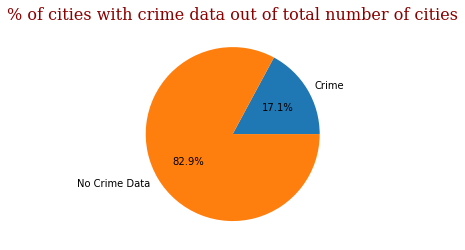

**Insight**: Only small portion of the cities in the cities file have crime data.<br><br>Total number of cities in the dataset is:<br>  1482<br>Number of cities with crime data in 2014-2019:<br>  254<br>

In [13]:
tot_num_of_cities =  df_cities.shape[0]
cities_of_crimes= len(df_crimes['סמל יישוב'].unique()[1:])
    

fig1, ax1 = plt.subplots()
labels=['Crime','No Crime Data']
plt.title('% of cities with crime data out of total number of cities',fontdict=font)
y = np.array([cities_of_crimes,(tot_num_of_cities - cities_of_crimes)])

plt.pie(y,labels =labels,autopct='%1.1f%%')
plt.show()


print("")



md(f"**Insight**: Only small portion of the cities in the cities file have crime data.<br><br>"
    f"Total number of cities in the dataset is:<br>  {tot_num_of_cities}<br>"
   f"Number of cities with crime data in 2014-2019:<br>  {cities_of_crimes}<br>"
)



**2.Total crime per category in each year**

**Insights**:<br>1. Total crime decreases over the years 2014-2019, the trend seems to be linear.<br>2. The propotions of different crime categories remain the same over the years.<br>

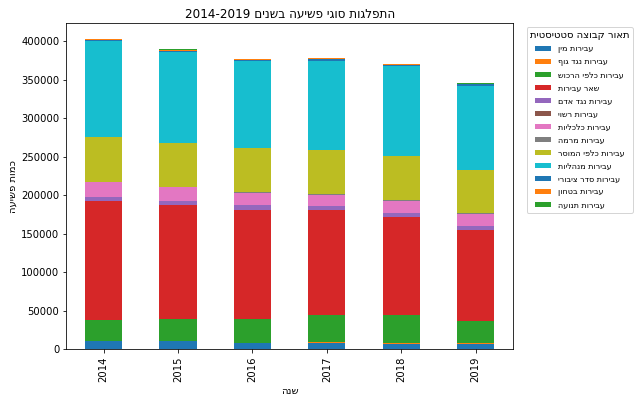

In [24]:
# Reversing string values in 'תאור קבוצה סטטיסטית' for graph diplay

def reverse(string):
    string = "".join(reversed(string))
    return string

crime_categories = list(set(df_crimes['תאור קבוצה סטטיסטית'].values))
crime_cat_reversed = []
for elm in crime_categories:
    crime_cat_reversed.append(reverse(elm))

reveresed_legend_title = reverse('תאור קבוצה סטטיסטית')

gk = df_crimes.groupby('תאור קבוצה סטטיסטית')[[2014,2015,2016,2017,2018,2019]].sum().reset_index()
# gk[2014].values

df = pd.concat([pd.DataFrame({2014:gk[2014].values}, index=gk['תאור קבוצה סטטיסטית']),
                pd.DataFrame({2015:gk[2015].values}, index=gk['תאור קבוצה סטטיסטית']),
                pd.DataFrame({2016:gk[2016].values}, index=gk['תאור קבוצה סטטיסטית']),
                pd.DataFrame({2017:gk[2017].values}, index=gk['תאור קבוצה סטטיסטית']),
                pd.DataFrame({2018:gk[2018].values}, index=gk['תאור קבוצה סטטיסטית']),
                pd.DataFrame({2019:gk[2019].values}, index=gk['תאור קבוצה סטטיסטית'])],
               axis=1, sort=False)

ax = df.T.plot.bar(stacked=True, figsize=(8,6),title=reverse('התפלגות סוגי פשיעה בשנים 9102-4102'))

ax.legend(crime_cat_reversed,loc='upper center', ncol=1, title=reveresed_legend_title,fontsize=8,bbox_to_anchor=(1.15, 1))
ax.set_xlabel(reverse("שנה"))
ax.set_ylabel(reverse("כמות פשיעה"))

md(f"**Insights**:<br>"
    f"1. Total crime decreases over the years 2014-2019, the trend seems to be linear.<br>"
   f"2. The propotions of different crime categories remain the same over the years.<br>"
)

**3. Crime categories distribution**

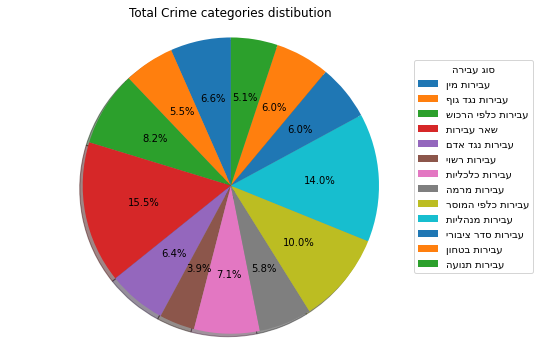

**Insights**:<br>1. We note that the relative % of each crime category corresponds to the % of that category in each year.<br>2. (colors from this diagaram and upper diagram have same proportions)

In [25]:
cities_without_crimes = []
# creating the symbol list of cities with crimes
cities_of_crime_symb = list(map(int,df_crimes['סמל יישוב'].unique()))

for city in df_cities['סמל יישוב']:    
    if city not in cities_of_crime_symb:
        cities_without_crimes.append(city)

gk = df_crimes.groupby('תאור קבוצה סטטיסטית').sum()
gk =gk.sum(axis = 1, skipna = True)

fig1, ax1 = plt.subplots()
fig1.set_figwidth(8)
fig1.set_figheight(6)
ax1.pie(gk.values, labels=gk.index, autopct='%1.1f%%',
        shadow=True, startangle=90,labeldistance=None)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Total Crime categories distibution')
ax1.legend(title=reverse('סוג עבירה'),labels = crime_cat_reversed,bbox_to_anchor=(0.9, 0.9))
plt.show()


md(f"**Insights**:<br>"
   f"1. We note that the relative % of each crime category corresponds to the % of that category in each year.<br>"
   f"2. (colors from this diagaram and upper diagram have same proportions)"
)

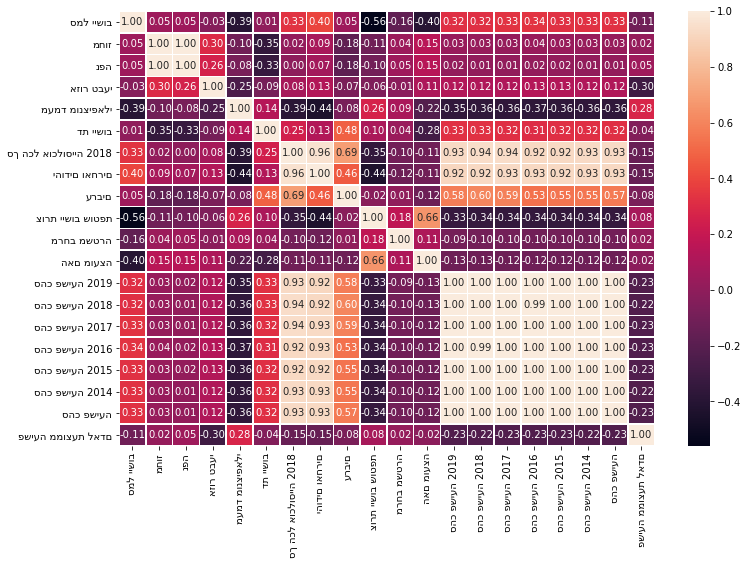

In [144]:
corrMatrix = final_cities_df.corr()
fig, ax = plt.subplots(figsize=(12,8))  
sns.heatmap(corrMatrix, annot=True,linewidths=.5, ax=ax,fmt=".2f")
plt.show()

**Analysis:**<br>
From the correlation Matrix we can see strong correlations between:<br> 

* Amount of total population of a city <=> Total crime amount in each year.
* Amount of Jews in a city <=> Total crime amount in each year.

These were expected as a linear correlations between population size and crime rate is obvious.

We see weak correlations between  
* District ('מחוז') <=> Total crime amount in each year
* Subdistrict ('נפה) <=> Total crime amount in each year
* Natural Zone ('אזור טבעי') <=> Total crime amount in each year
* Police Area ('מרחב משטרה') <=> Total crime amount in each year

These weren't expected, it indicates that crime spreads quite uniformly between Districts,Zones and police areas

# Tasks 3: **Creating 2 clustering models (KMeans + GMM/EM)**
## A. KMeans
*In KMeans, the following assumptions exist:
* Variance of the distribution of each attribute (variable) is spherical.

* All variables have the same variance.

* The prior probability for all k clusters are the same, i.e. each cluster has roughly equal number of observations; If any   one of these 3 assumptions is violated, then k-means will fail.

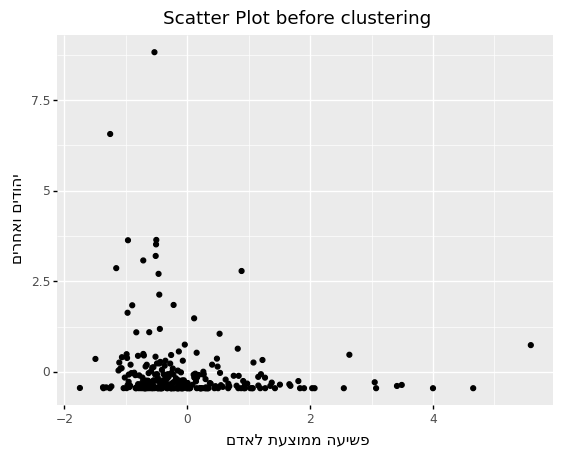

<ggplot: (92398274012)>

In [146]:
features = ['פשיעה ממוצעת לאדם','יהודים ואחרים']
X = final_cities_df[features]
# Scaling the feature vector for elimnating the difference in scales (using Sklearn's Standardsclaer)
z = StandardScaler()
X[features] = z.fit_transform(X)
(ggplot(X, aes(features[0],features[1])) + geom_point()) + labs(x=reverse(features[0]), y = reverse(features[1]))+ ggtitle("Scatter Plot before clustering")


### Model Evaluation &  Optimization (number of clusters)

*We will use the Silhouette Coefficient and the elbow method to optimize our model:*<br>

* **The Silhouette Coefficient** measures the mean intra-cluster distance and the mean nearest-cluster distance for the cluster evaluation,<br>
Silhouette score is given in the interval [-1,1] (Optimal = 1)

* **The elbow method** uses the inertia value: mean squared distance between each instance and its closest centroid)

In [147]:
inertia = []
for k in range(1, 13):
    km = KMeans(n_clusters=k)
    km.fit(X)
    memebership = km.predict(X)
    X["cluster"] = memebership
    inertia.append(km.inertia_)
    
cluster_df = pd.DataFrame({'Cluster':range(1,13), 'Inertia':inertia})

silhouette_scores = []
for k in range(1, 13):
    km.fit(X)
    memebership = km.predict(X)
    X["cluster"] = memebership
    silhouette_scores.append(silhouette_score(X,memebership))
    
cluster_df['Silhouette scores'] = silhouette_scores
cluster_df

,Cluster,Inertia,Silhouette scores
0,1,510.000000,0.767497
1,2,328.815580,0.767257
2,3,179.194833,0.783063
3,4,136.875337,0.791520
4,5,97.023762,0.731669
5,6,66.413153,0.781729
6,7,56.908828,0.761676
7,8,50.727697,0.811108
8,9,44.760171,0.753401
9,10,39.531948,0.748583


**Above are scores of each # of cluster (n)  -we aim for low Inertia and high Silhouette scores**<br>
**Down are diagrams for opimization of cluster # via the 2 parameters**

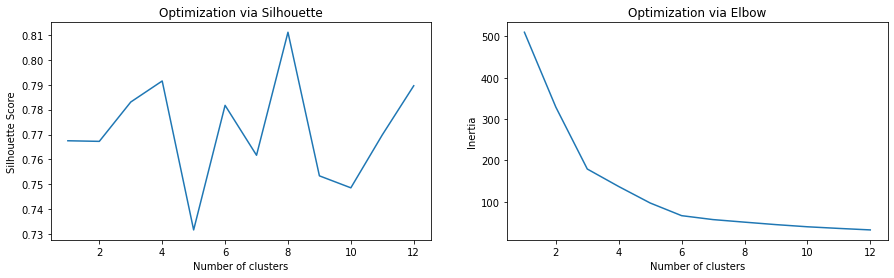

In [148]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4))

ax1.set_title('Optimization via Silhouette')
ax1.plot(cluster_df['Cluster'], cluster_df['Silhouette scores'])
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhouette Score')

ax2.set_title('Optimization via Elbow')
ax2.plot(cluster_df['Cluster'], cluster_df['Inertia'])
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Inertia')
plt.show()

**Analysis:**<br>
- From the elbow optimization we can see that K = 3..12 is quite stable.<br>
- We see that there is a local peak in the silhouette values on K=4,<br>

**Conclusion:**<br>
- Therefore, after considering both elbow and silhouette we select **K=4** [4..12].


**Running The optimized Model (K=4)**<br>


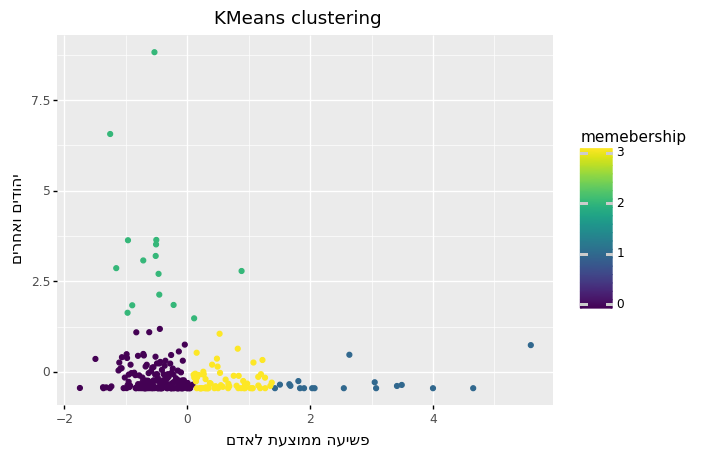

<ggplot: (92398233616)>

In [150]:
km = KMeans(n_clusters=4, random_state=SEED)
km.fit(X)
memebership = km.predict(X)
X["cluster"] = memebership
(ggplot(X, aes(features[0],features[1],color = 'memebership')) + geom_point()) + labs(x=reverse(features[0]), y = reverse(features[1]))+ ggtitle("KMeans clustering")


In [151]:
KMeans_sil = silhouette_score(X,memebership)
KMeans_sil

0.7691887277460325

#### Conclusion:

* We found that  4 clusters best describe the relationship between  average crime per person and jews population size in cities
* We note that the most dense cluster is the purple which characterized by quite low jew population and low value of average crime per person.

* Our conclusion is that there is a strong relation between jew population in cities to average crime per person

## B. GMM/EM
**Gaussian Mixture Model - Expectaion Maximization**<br>
This Model assumes all the data points are generated from a mixture of a finite number of Gaussian distributions

**Optimization** - selecting the optimized number of clusters from [1..21], based on the BIC,AIC criterions and silhouette scores

- AIC tries to select the model that most adequately describes an unknown, high dimensional reality. This means that reality is never in the set of candidate models that are being considered.
- BIC tries to find the TRUE model among the set of candidates.

Text(0, 0.5, 'BIC\\AIC')

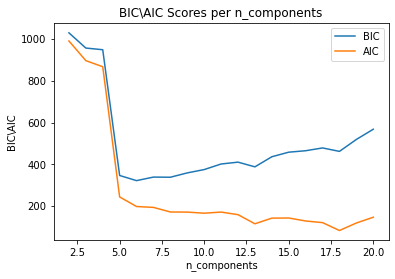

In [179]:
features = ['פשיעה ממוצעת לאדם','יהודים ואחרים']
X = final_cities_df[features]
# Scaling the feature vector for elimnating the difference in scales (using Sklearn's Standardsclaer)
z = StandardScaler()
X[features] = z.fit_transform(X)

n_components = np.arange(2, 21)
models = [GaussianMixture(n).fit(X)
          for n in n_components]
plt.title('BIC\AIC Scores per n_components')
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC\AIC')


In [180]:
silhouette_scores = []
for k in range(2, 21):
    EM = GaussianMixture(n_components=k).fit(X)
    cluster = EM.predict(X)
    silhouette_scores.append(silhouette_score(X,cluster))



In [181]:
cluster_df = pd.DataFrame({'Cluster':range(2,21), 
                           'BIC':[m.bic(X) for m in models], 
                           'AIC':[m.aic(X) for m in models],
                          'silhouette scores':silhouette_scores})
cluster_df

,Cluster,BIC,AIC,silhouette scores
0,2,1030.250489,991.296590,0.460066
1,3,957.417738,897.216258,0.567809
2,4,949.371638,867.922577,0.561017
3,5,347.168725,244.472082,0.128293
4,6,322.551307,198.607083,0.079155
5,7,339.521894,194.330089,0.071193
6,8,338.797885,172.358498,0.024615
7,9,359.576254,171.889286,-0.024869
8,10,375.515524,166.580975,0.017489
9,11,402.154126,171.971995,0.010665


<function matplotlib.pyplot.show(close=None, block=None)>

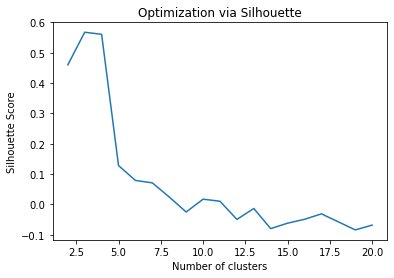

In [182]:
plt.title('Optimization via Silhouette')
plt.plot(cluster_df['Cluster'], cluster_df['silhouette scores'])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show


**Analysis:**<br>
We aim to find the number of cluster which minimize the BIC and AIC values and Maximized silhouette score,<br> 
based on the diagram  & table, we can see that a n_components = 3 is the best value.

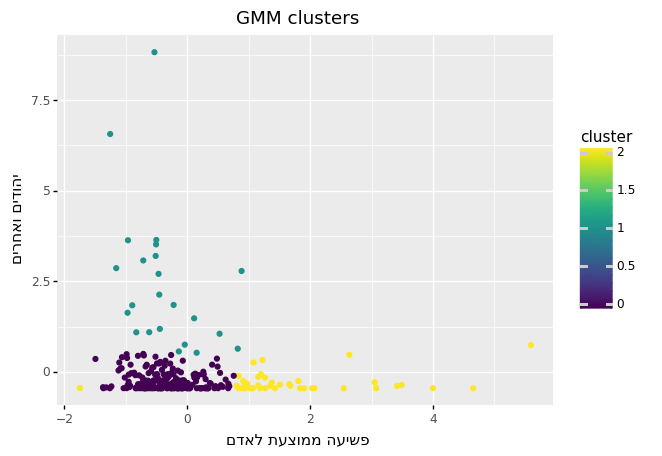

<ggplot: (92394563847)>

In [196]:
features = ['פשיעה ממוצעת לאדם','יהודים ואחרים']
X = final_cities_df[features]
# Scaling the feature vector for elimnating the difference in scales (using Sklearn's Standardsclaer)
z = StandardScaler()
X[features] = z.fit_transform(X)

EM = GaussianMixture(n_components=3,random_state=SEED)
EM.fit(X)
cluster = EM.predict(X)
(ggplot(X, aes(features[0],features[1],color = 'cluster')) + geom_point()) + labs(x=reverse(features[0]), y = reverse(features[1]))+ ggtitle("GMM clusters")


In [197]:
GMM_sil = silhouette_score(X,cluster)
GMM_sil

0.5678089366973149

## C.Comparing the 2 Models 
We will compare the silhouette scores of the 2 optimzed models for choosing  the best model

In [198]:
df_compare = pd.DataFrame({'Model':['KMeans','GMM'], 'Silhouette Score':[KMeans_sil,GMM_sil]})
df_compare

,Model,Silhouette Score
0,KMeans,0.769189
1,GMM,0.567809


**Conclusion**:
The better model is KMeans due to its higher score

# Tasks 5: Prediction via AdaBoost
**We will try to predict total crimes on 2019 in 
'קריית אתא','סחנין','ראש פינה','אילת','באר שבע', using 2014-2018 data and demographic features**<br>
**We will evaluate our models using the MSE (means squared error) and R2 score**

In [199]:
# Preparing the data according the task by seperate train data and test data
predict_cities = ['קריית אתא','סח\'נין','ראש פינה','אילת','באר שבע']
filt_pred_cities = final_cities_df['שם יישוב'].isin(predict_cities)
data_pred =final_cities_df[filt_pred_cities]
filt_train_cities = final_cities_df['שם יישוב'].isin(predict_cities) == False
data_train = final_cities_df[filt_train_cities]

In [200]:
# choosing features for the learning of the algorithm 
features_ada = ['סך הכל אוכלוסייה 2018','סהכ פשיעה 2018','סהכ פשיעה 2014','סהכ פשיעה 2015','סהכ פשיעה 2016','סהכ פשיעה 2017','אזור טבעי']
data_ada_features = data_train[features_ada]
data_ada_labels = data_train['סהכ פשיעה 2018']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(data_ada_features, data_ada_labels, test_size=0.3,
                                                    shuffle=True,random_state=SEED)

# Build the AdaBoost model 
ada = AdaBoostRegressor()

# Optimization to the model
params = {
 'n_estimators': [40,50,60,80,100],
 'learning_rate' : [0.01, 0.05, 0.1, 0.5, 1],
 'loss' : ['linear', 'square', 'exponential']
 }

random = RandomizedSearchCV(ada, params, random_state=SEED)
search = random.fit(X_train, y_train)
print("The best parameters we got: ",search.best_params_)

# Create new model according to the best parameters we got
estim = search.best_estimator_
ada_best = AdaBoostRegressor(estim)

The best parameters we got:  {'n_estimators': 100, 'loss': 'square', 'learning_rate': 1}


In [201]:
# Train the model
ada_best.fit(X_train, y_train)
print("feature importances: " ,ada_best.feature_importances_)
# Predict the response for test dataset
y_pred=ada_best.predict(X_test)
print("The mean squared error: " , mean_squared_error(y_test, y_pred))
score = ada_best.score(X_test,y_test)
print("The R2 score is: ",score)

feature importances:  [0.13472921 0.19143453 0.18394679 0.15014953 0.16231672 0.17162942
 0.00579379]
The mean squared error:  42950.290892635785
The R2 score is:  0.9862164570970331


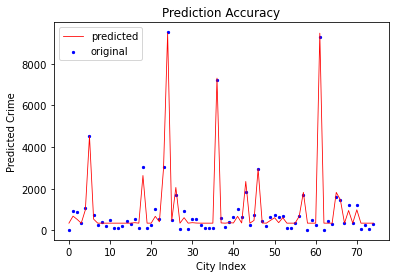

In [202]:
# Visualization of the results
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.xlabel("City Index")
plt.ylabel("Predicted Crime")
plt.title("Prediction Accuracy")
plt.show()


We can see from the scores and the diagram that accuracy of prediction is fairly good.

In [206]:
# Predict the results of the real set test
data_pred_check = data_pred[features_ada]
results = ada_best.predict(data_pred_check)

# intialise data of lists.
data = {'סמל יישוב': data_pred['סמל יישוב'],
        'שם יישוב' : data_pred['שם יישוב'],
        'Results':results,
       'crimes_2019':data_pred['סהכ פשיעה 2019']}
  
# Display the results at table
df_results = pd.DataFrame(data)
print("The mean squared error: " , mean_squared_error(data_pred['סהכ פשיעה 2019'], results))

score = ada_best.score(data_pred_check,data_pred['סהכ פשיעה 2019'])
print("The R2 score is: ",score)
df_results


The mean squared error:  328789.85636035306
The R2 score is:  0.989228669859652


,סמל יישוב,שם יישוב,Results,crimes_2019
9,2600,אילת,7082.750000,5942
22,9000,באר שבע,15760.000000,15286
139,7500,סח'נין,755.902439,942
167,6800,קריית אתא,2675.750000,2415
180,26,ראש פינה,349.854167,226


**We can see in the dataframe above, the actual crime ammount (crimes_2019) and predicted crime amount (results)**

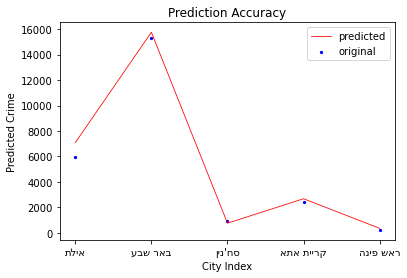

In [222]:
# Visualization of the results
x_ax = list(data_pred['שם יישוב'])
for n in range(len(x_ax)):
    x_ax[n] = reverse(x_ax[n])

plt.scatter(x_ax, data_pred['סהכ פשיעה 2019'], s=5, color="blue", label="original")
plt.plot(x_ax, results, lw=0.8, color="red", label="predicted")
plt.legend()
plt.xlabel("City Index")
plt.ylabel("Predicted Crime")
plt.title("Prediction Accuracy")
plt.show()


**Analysis:**
It can be seen from the graph that the predictions are relatively accurate, most od theblue dots (actual values overlapp our prediction line (in red) or very close.<br>
we will try to improve our model by adding more demographic features.

**Second Try (Including more features)**

The best parameters we got:  {'n_estimators': 80, 'loss': 'exponential', 'learning_rate': 0.05}
The mean squared error:  38614.46683140859
The R2 score is:  0.9876079032485162


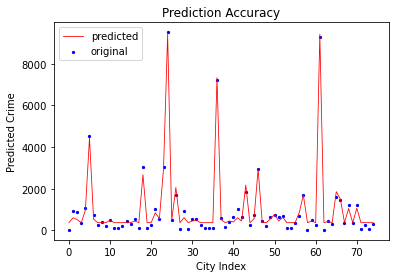

In [226]:
# Adding features for more accurate predictions
more_features = ['מרחב משטרה','אזור טבעי','סך הכל אוכלוסייה 2018'
                 ,'סהכ פשיעה 2018','סהכ פשיעה 2014','סהכ פשיעה 2015','סהכ פשיעה 2016','סהכ פשיעה 2017','ערבים']
second_ada_features = data_train[more_features]

X2_train, X2_test, y2_train, y2_test = train_test_split(second_ada_features, data_ada_labels, test_size=0.3,
                                                        shuffle=True, random_state=SEED)


random2 = RandomizedSearchCV(ada, params, random_state=SEED)
search2 = random2.fit(X2_train, y2_train)
print("The best parameters we got: ",search2.best_params_)

# Create new model according to the best parameters we got
estim2 = search.best_estimator_

ada2_best = AdaBoostRegressor(estim2)

ada2_best.fit(X2_train, y2_train)
y2_pred=ada2_best.predict(X2_test)
print("The mean squared error: " , mean_squared_error(y2_test, y2_pred))
score = ada2_best.score(X2_test,y2_test)
print("The R2 score is: ",score)

x_ax = range(len(y2_test))
plt.scatter(x_ax, y2_test, s=5, color="blue", label="original")
plt.plot(x_ax, y2_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.xlabel("City Index")
plt.ylabel("Predicted Crime")
plt.title("Prediction Accuracy")
plt.show()

In [229]:
data2_test_check = data_pred[more_features]
second_results = ada2_best.predict(data2_test_check)

print("The mean squared error: " , mean_squared_error(data_pred['סהכ פשיעה 2019'], results))
score = ada2_best.score(data2_test_check,data_pred['סהכ פשיעה 2019'])
print("The R2 score is: ",score)

data2 = {'סמל יישוב':data_pred['סמל יישוב'],
         'שם יישוב' : data_pred['שם יישוב'],
        'Results':second_results,
       'crimes_2019':data_pred['סהכ פשיעה 2019']}
  
# Display the results at table
df2_results = pd.DataFrame(data2)
df2_results

The mean squared error:  328789.85636035306
The R2 score is:  0.9893025347602449


,סמל יישוב,שם יישוב,Results,crimes_2019
9,2600,אילת,7061.4000,5942
22,9000,באר שבע,15760.0000,15286
139,7500,סח'נין,904.0000,942
167,6800,קריית אתא,2778.1875,2415
180,26,ראש פינה,372.9500,226


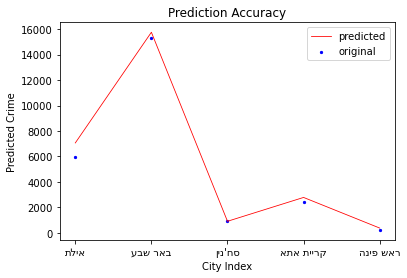

In [230]:
x_ax = list(data_pred['שם יישוב'])
for n in range(len(x_ax)):
    x_ax[n] = reverse(x_ax[n])

plt.scatter(x_ax, data_pred['סהכ פשיעה 2019'], s=5, color="blue", label="original")
plt.plot(x_ax, second_results, lw=0.8, color="red", label="predicted")
plt.legend()
plt.xlabel("City Index")
plt.ylabel("Predicted Crime")
plt.title("Prediction Accuracy")
plt.show()

**Conclusion:** The accuracy stays about the same after training the model with more features. 

# Tasks 6: Classification via AdaBoost
**we will use the following method:
#### we define 3 classes:
* Reinforce in 2019
* Decrease work in 2019.
* No change in 2019
We chose the AdaBoost algorithm for classifying the datapoints<br>

**We trained our model to classify these classes as follows:**<br>
We train the model on crime in 2014-2017 with addition to demographic features to predict the classes of 2018.<br>
After the model was trained, we used 2015-2018 years and same demographic features to predict 2019 classes 

**We created a dictionary with crime categories and hour cost per category, we use this dictionary later on to calculate the amount of total work hours needed for each city.**

In [246]:
hours = {'עבירות בטחון': 20,
        'עבירות כלכליות':5,
       'עבירות כלפי המוסר':15,
        'עבירות כלפי הרכוש': 10,
        'עבירות מין': 35,
        'עבירות מרמה': 25,
        'עבירות נגד אדם': 40,
        'עבירות נגד גוף': 30,
        'עבירות תנועה': 2}

df_crimes_hours = merged_final_cities_df[['סמל יישוב','יישוב מחושב','תאור קבוצה סטטיסטית',2014,2015,2016,2017,2018,2019]]

In [247]:
# Calculating the hours for each type of crime
for index, row in df_crimes_hours.iterrows():
    if row['תאור קבוצה סטטיסטית'] in hours:
        df_crimes_hours.at[index,2014] = row[2014]* hours.get(row['תאור קבוצה סטטיסטית'])
        df_crimes_hours.at[index,2015] = row[2015]* hours.get(row['תאור קבוצה סטטיסטית'])
        df_crimes_hours.at[index,2016] = row[2016]* hours.get(row['תאור קבוצה סטטיסטית'])
        df_crimes_hours.at[index,2017] = row[2017]* hours.get(row['תאור קבוצה סטטיסטית'])
        df_crimes_hours.at[index,2018] = row[2018]* hours.get(row['תאור קבוצה סטטיסטית'])
        df_crimes_hours.at[index,2019] = row[2019]* hours.get(row['תאור קבוצה סטטיסטית'])

df_crimes_hours.sample(10)

,סמל יישוב,יישוב מחושב,תאור קבוצה סטטיסטית,2014,2015,2016,2017,2018,2019
2503,7800.0,פרדס חנה כרכור,עבירות סדר ציבורי,510,467,437,502,540,541
1466,-28.0,מועצה אזורית ברנר,עבירות מרמה,150,50,75,100,75,200
2094,518.0,מעיליא,עבירות רשוי,1,2,0,0,0,0
436,9800.0,בנימינה גבעת עדה,עבירות נגד אדם,0,80,0,80,40,0
2941,1304.0,שוהם,עבירות מנהליות,0,0,1,0,0,0
174,3560.0,אלקנה,עבירות נגד גוף,300,150,270,300,150,180
2219,7300.0,נצרת,עבירות מנהליות,0,0,1,3,0,0
1491,-71.0,מועצה אזורית גולן,עבירות תנועה,2,0,8,14,6,4
1564,-1.0,מועצה אזורית הגליל העליון,עבירות סדר ציבורי,97,110,112,95,122,100
1674,-15.0,מועצה אזורית חוף הכרמל,שאר עבירות,1,1,1,1,0,0


**We replaced the values of crime aounts with the calculate values of the hours * crimes, using our dictionary.**

In [248]:
# Summarized the average amount of work hours for police officers 
df_crimes_hours = df_crimes_hours.groupby(['יישוב מחושב'])[[2019,2018,2017,2016,2015,2014]].sum().reset_index()
df_crimes_hours.iloc[:, 0].rename('יישוב מחושב')

# Prepering dataframe wich fits to the current task
# Classification of data into appropriate classes according to the conditions
# Create 3 classes according to the task: "הפחתה", "תגבור", "אין שינוי"
class_conditions = [df_crimes_hours[2019] > df_crimes_hours[2018], 
                   df_crimes_hours[2019] < df_crimes_hours[2018]]
class_choices = ['Reinforce', 'Decrease']
df_crimes_hours['Class_2019'] = np.select(class_conditions, class_choices, default= 'אין שינוי')
class2018_conditions = [df_crimes_hours[2018] > df_crimes_hours[2017], 
                   df_crimes_hours[2018] < df_crimes_hours[2017]]
class2018_choices = ['Reinforce', 'Decrease']
df_crimes_hours['Class_2018'] = np.select(class2018_conditions, class2018_choices, default= 'אין שינוי')

# Merge the amount of work hours with the demographic data 
merged_final_cities_df.drop(columns=[2014,2015,2016,2017,2018,2019,'תאור קבוצה סטטיסטית'], inplace=True)
df_task6 = pd.merge(merged_final_cities_df, df_crimes_hours, on='יישוב מחושב')
df_task6.drop_duplicates(subset="סמל יישוב", inplace=True)
df_task6.sample(10)


,סמל יישוב,יישוב מחושב,מחוז,נפה,אזור טבעי,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,יהודים ואחרים,ערבים,צורת יישוב שוטפת,מרחב משטרה,האם מועצה,2019,2018,2017,2016,2015,2014,Class_2019,Class_2018
1592,-78.0,מועצה אזורית הר חברון,7,77,-1.0,78.0,1.0,10167.0,8897.0,0.0,370,15003512.0,True,4625,3146,2640,2808,2766,3153,Reinforce,Reinforce
111,2600.0,אילת,6,62,625.0,0.0,1.0,51935.0,49675.0,2260.0,150,10001955.0,False,76746,85019,85171,91870,88420,89778,Decrease,Decrease
2227,2500.0,נשר,3,31,311.0,0.0,1.0,23983.0,23745.0,238.0,160,10004207.0,False,9338,9313,10032,10718,11594,10605,Reinforce,Decrease
1293,516.0,מג'ד אל כרום,2,24,242.0,99.0,2.0,15292.0,20.0,15272.0,270,15002358.0,False,7548,7844,8677,7710,7160,6401,Decrease,Decrease
2960,538.0,שעב,2,24,241.0,99.0,2.0,6941.0,3.0,6938.0,280,15002411.0,False,2803,2346,2490,2593,2641,2751,Reinforce,Decrease
187,3650.0,אפרת,7,76,-1.0,99.0,1.0,10088.0,10088.0,0.0,170,15000586.0,False,1728,1842,1900,1822,1069,1016,Decrease,Decrease
1233,1139.0,כרמיאל,2,24,242.0,0.0,1.0,46124.0,44617.0,1507.0,160,10004465.0,False,21537,23306,22178,22471,23147,18805,Decrease,Reinforce
124,478.0,אכסאל,2,23,237.0,99.0,2.0,14500.0,6.0,14494.0,270,10004394.0,False,5228,4424,4040,2821,3616,4108,Reinforce,Reinforce
1256,7000.0,לוד,4,43,432.0,0.0,4.0,75726.0,52590.0,23136.0,150,10002261.0,False,52134,58312,57998,52059,64346,71911,Decrease,Reinforce
2096,3616.0,מעלה אדומים,7,76,-1.0,0.0,1.0,38193.0,38129.0,64.0,160,10003314.0,False,13450,15852,17484,19966,21529,21883,Decrease,Decrease


#### Above is the dataframe which stores the data used to train the model (X) and also the lables (y)

In [251]:
# choosing features for the learning of the algorithm 
features_task6 =[2014,2015,2016,2017,'נפה','אזור טבעי','סך הכל אוכלוסייה 2018','יהודים ואחרים','מרחב משטרה','האם מועצה','צורת יישוב שוטפת']
data_task6_features = df_task6[features_task6]
data_task6_lables = df_task6['Class_2018']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(data_task6_features, data_task6_lables, test_size=0.3,
                                                    shuffle=True, random_state=SEED)

# Build the AdaBoost model 
adab = AdaBoostClassifier()

# Optimization to the model
adab_param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                  'random_state': [SEED]}

gs_adab = GridSearchCV(adab, param_grid = adab_param_grid, cv=5, scoring="accuracy", n_jobs= -1)

gs_adab.fit(X_train,y_train)

ADB_best = gs_adab.best_estimator_

print("Best Parameters:\n", gs_adab.best_params_)


Best Parameters:
 {'learning_rate': 0.1, 'n_estimators': 200, 'random_state': 42}


The accuracy:  0.6233766233766234


Text(0.5, 1.0, 'Feature Importance')

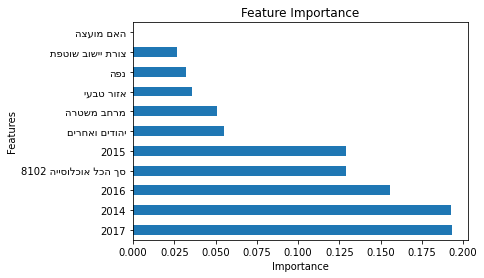

In [264]:
# Create new model according to the best parameters we got
adab_best = AdaBoostClassifier(ADB_best)

# Train the model
adab_best.fit(X_train, y_train)

# Predict the response for test dataset
y_pred=adab_best.predict(X_test)
print("The accuracy: ",metrics.accuracy_score(y_test,y_pred))

# Reversing the hebrew labels of axis y
lables = list(data_task6_features.columns)
for n in range(len(lables)):
    if type(lables[n]) != int:
        lables[n] = reverse(lables[n])
        
# Display the importance of each feature
feat_importances = pd.Series(adab_best.feature_importances_, index=lables)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')

**Acording to the feature importance values we remove the unimportant features in order to optimize the model.**<br>
We removed : "האם מועצה", "צורת יישוב שוטפת","נפה"

In [267]:
features_try2 = [2014,2016,2017,2015,'אזור טבעי','סך הכל אוכלוסייה 2018','יהודים ואחרים','מרחב משטרה']
data_try2_features = df_task6[features_try2]

# Split dataset into training set and test set
X2_train, X2_test, y2_train, y2_test = train_test_split(data_try2_features, data_task6_lables, test_size=0.3,
                                                        shuffle=True, random_state=SEED)
# Optimization to the model
gs_adab.fit(X2_train,y2_train)

ADB_best = gs_adab.best_estimator_

print("Best Parameters:\n", gs_adab.best_params_)

Best Parameters:
 {'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 42}


The accuracy:  0.6493506493506493


Text(0.5, 1.0, 'Second Trial: Feature Importance')

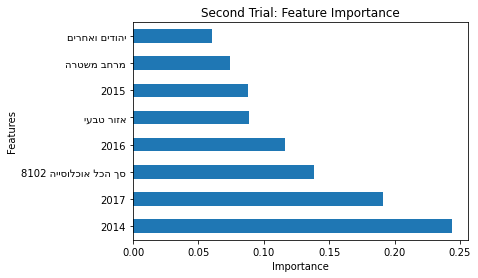

In [270]:
# Create new model according to the best parameters we got
adab2_best = AdaBoostClassifier(ADB_best)

# Train the model
adab2_best.fit(X2_train, y2_train)

# Predict the response for test dataset
y2_pred=adab2_best.predict(X2_test)
print("The accuracy: ",metrics.accuracy_score(y2_test,y2_pred))

# Reversing the hebrew labels of axis y
lables = list(data_try2_features.columns)
for n in range(len(lables)):
    if type(lables[n]) != int:
        lables[n] = reverse(lables[n])
        
# Display the importance of each feature    
feat2_importances = pd.Series(adab2_best.feature_importances_, index=lables)
ax = feat2_importances.nlargest(20).plot(kind='barh')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Second Trial: Feature Importance')

**As can be seen from the accuracy value, the accuracy was improved a bit by removing the unimportant features**

**Down, we will display the final prediction result in a dataframe,scatter plot & confusion matrix**

In [273]:
# Predict the results of the real set test 
data_test_task6 = df_task6[[2015,2016,2017,2018,'אזור טבעי','סך הכל אוכלוסייה 2018','יהודים ואחרים','מרחב משטרה']]
results_task6 = adab2_best.predict(data_test_task6)

print(metrics.accuracy_score(df_task6['Class_2019'], results_task6))

# intialise data of lists.
data_task6 = {'שם יישוב':df_task6['יישוב מחושב'],
        'Results':results_task6,
       'Class_2019':df_task6['Class_2019']}
  
# Display the results at table
df_results_task6 = pd.DataFrame(data_task6)
df_results_task6.head(20)


0.5215686274509804


,שם יישוב,Results,Class_2019
0,אבו גוש,Decrease,Reinforce
12,אבו סנאן,Decrease,Reinforce
24,אבן יהודה,Decrease,Decrease
37,אום אל פחם,Reinforce,Decrease
50,אופקים,Reinforce,Decrease
63,אור יהודה,Decrease,Decrease
76,אור עקיבא,Reinforce,Decrease
87,אורנית,Decrease,Decrease
98,אזור,Reinforce,Reinforce
111,אילת,Reinforce,Decrease


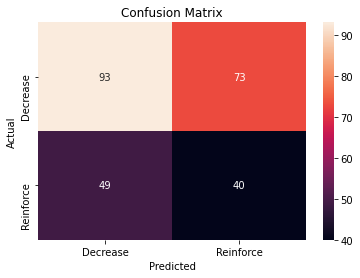

In [275]:
confusion_matrix = pd.crosstab(df_results_task6['Class_2019'], df_results_task6['Results'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.title("Confusion Matrix")
plt.show()

**We can see from the Matrix that 133 of the cities were classfied correctly (TP+TN) and 122 were not (FP+FN)**


Text(0.5, 1.0, 'Visualization of Classes')

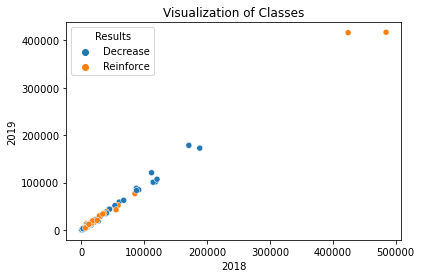

In [302]:
sns.scatterplot(data=data_test_task6, x=df_task6[2018], y=df_task6[2019], hue= df_results_task6['Results'])
plt.title("Visualization of Classes")

**Axis x represents the amunt of required hours in 2018, Axis y displays the actual requried hours in 2019.<br>
the color of the points represent the classes, we tryed to see if all the orange dots (Reinforce hours) are at the upper left section of the diagram (where Y>X) and blue are closer to the bottom right (X>Y)**

## TASK 7
**We took the clusters from the Kmeans model due to its better performance in task 3.<br>
We used the clusters from task 3 as a new feature for classification and running again the model from task 6**

In [303]:
# Adding the feature from task3
df_task6['task3'] = memebership
features_task7 = [2014,2016,2017,2015,'אזור טבעי','סך הכל אוכלוסייה 2018','יהודים ואחרים','מרחב משטרה','task3']
data_task7_features = df_task6[features_task7]

# Split dataset into training set and test set
X7_train, X7_test, y7_train, y7_test = train_test_split(data_task7_features, data_task6_lables, test_size=0.3,
                                                        shuffle=True, random_state=SEED)
# Optimization to the model
gs_adab.fit(X7_train,y7_train)

ADB_best = gs_adab.best_estimator_

print("Best Parameters:\n", gs_adab.best_params_)

Best Parameters:
 {'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 42}


The accuracy:  0.6363636363636364


Text(0.5, 1.0, 'Feature Importance')

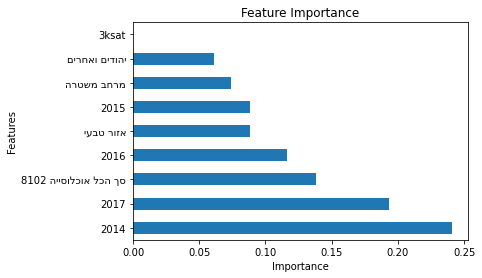

In [304]:
# Create new model according to the best parameters we got
adab7_best = AdaBoostClassifier(ADB_best)

# Train the model
adab7_best.fit(X7_train, y7_train)

# Predict the response for test dataset
y7_pred=adab7_best.predict(X7_test)
print("The accuracy: ",metrics.accuracy_score(y7_test,y7_pred))

# Reversing the hebrew labels of axis y
lables = list(data_task7_features.columns)
for n in range(len(lables)):
    if type(lables[n]) != int:
        lables[n] = reverse(lables[n])

feat7_importances = pd.Series(adab7_best.feature_importances_, index=lables)
ax = feat7_importances.nlargest(20).plot(kind='barh')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')

**From the feature importance we can see that the added feature was meaningless and added no value to the model,<br>
Therefore, adding this feature doesnt change the result and accuracy**

In [305]:
# Predict the results of the real set test 
data_test_task7 = df_task6[[2015,2016,2017,2018,'אזור טבעי','סך הכל אוכלוסייה 2018','יהודים ואחרים','מרחב משטרה','task3']]
results_task7 = adab7_best.predict(data_test_task7)

print(metrics.accuracy_score(df_task6['Class_2019'], results_task7))

# intialise data of lists.
data_task7 = {'שם יישוב':df_task6['יישוב מחושב'],
        'Results':results_task7,
       'Class_2019':df_task6['Class_2019'],
             'task3': df_task6['task3']}
  
# Display the results at table
df_results_task7 = pd.DataFrame(data_task7)
df_results_task7.head(20)


0.5215686274509804


,שם יישוב,Results,Class_2019,task3
0,אבו גוש,Decrease,Reinforce,0
12,אבו סנאן,Decrease,Reinforce,3
24,אבן יהודה,Decrease,Decrease,0
37,אום אל פחם,Reinforce,Decrease,0
50,אופקים,Reinforce,Decrease,0
63,אור יהודה,Decrease,Decrease,0
76,אור עקיבא,Reinforce,Decrease,0
87,אורנית,Decrease,Decrease,0
98,אזור,Reinforce,Reinforce,0
111,אילת,Reinforce,Decrease,0


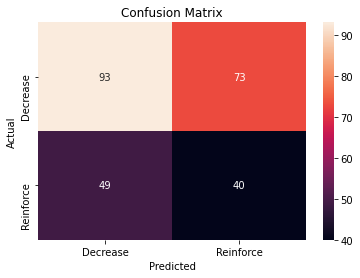

In [306]:
confusion_matrix = pd.crosstab(df_results_task7['Class_2019'], df_results_task7['Results'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.title("Confusion Matrix")
plt.show()

**We can see from the Matrix that 133 of the cities were classfied correctly (TP+TN) and 122 were not (FP+FN)**
Suprisingly, we received the same results as task 6, thefore this further indicates that the clusters from task 3, didn't imporve nor decrease the performance of the model.
